## General information

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data.
Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

This is my second kernel for this competition, here is the [link](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline) to the first one.

In this kernel I'll try to create more useful features and generate more data for training.

![](https://i.cbc.ca/1.4972912.1547133821!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/new-brunswick-earthquake.jpg)

In [5]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

from numba import jit

In [6]:
#%%time
#df_train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})
df_train = pd.read_hdf("../input/train.hdf", key='0')
#train = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})

In [7]:
#df_train.to_hdf("../input/train.hdf", key='0')

In [8]:
df_train.head()

,acoustic_data,time_to_failure
0,12.0,1.469099998474121
1,6.0,1.469099998474121
2,8.0,1.469099998474121
3,5.0,1.469099998474121
4,8.0,1.469099998474121


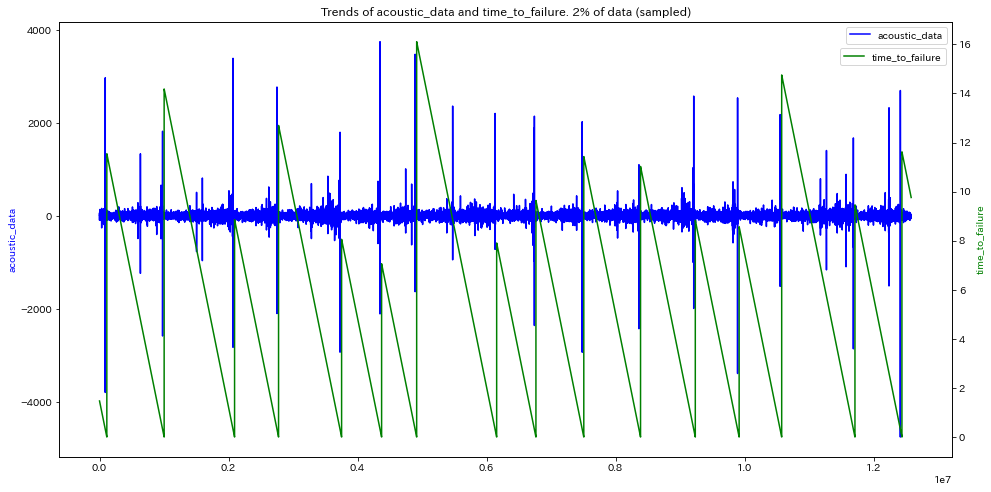

In [9]:
train_acoustic_data_small = df_train['acoustic_data'].values[::50]
train_time_to_failure_small = df_train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

* We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
* Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;
* I thought that comparing max values of signal in a segment to some threshold value (1000 or 2000) could be useful, but it didn't work;

## Feature generation

I create several groups of features:
* Usual aggregations: mean, std, min and max;
* Average difference between the consequitive values in absolute and percent values;
* Absolute min and max vallues;
* Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
* Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
* Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
* Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
* Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [10]:
# Create a training file with simple derived features
rows = 150000
segments = int(np.floor(df_train.shape[0] / rows))

In [11]:
segments

4194

In [12]:
def add_trend_feature(arr, abs_values=False):
    """
    単回帰を用いてデータの平均傾きを出力
    """
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    """
    STA/LTA (short-term average/long-term average)
    For noise-free seismograms, the maximum value of the numerical derivative of the STA/LTA ratio is close to the time of the first arrival.
    (https://en.wikipedia.org/wiki/First_break_picking)
    length_staだけズラした波形の振幅の累積二乗の比率/length_finだけズラした波形の振幅の累積二乗の比率
    """
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    sta[:length_lta - 1] = 0 # Pad zeros
    
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [13]:
def calc_change_rate(x):
    """
    現在の値から次の値への変化率の平均値を返す
    """
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [17]:
def generate_features(x_in, X_out, i):
    """
    x_in:特徴量の統計量を算出する一定時間の数値ベクトル 
    X_out:計算した特徴量を格納するDataFrame
    i:x_inで計算したデータをX_outに格納する際の行番号
    """
    # 特徴量変換
    X_out.loc[i, 'mean'] = x_in.mean()
    X_out.loc[i, 'std'] = x_in.std()
    X_out.loc[i, 'max'] = x_in.max()
    X_out.loc[i, 'min'] = x_in.min()
    
    X_out.loc[i, 'mean_change_abs'] = np.mean(np.diff(x_in))
    X_out.loc[i, 'mean_change_rate'] = calc_change_rate(x_in)
    X_out.loc[i, 'abs_max'] = np.abs(x_in).max()
    X_out.loc[i, 'abs_min'] = np.abs(x_in).min()
    
    X_out.loc[i, 'std_first_50000'] = x_in[:50000].std()
    X_out.loc[i, 'std_last_50000'] = x_in[-50000:].std()
    X_out.loc[i, 'std_first_10000'] = x_in[:10000].std()
    X_out.loc[i, 'std_last_10000'] = x_in[-10000:].std()
    
    X_out.loc[i, 'avg_first_50000'] = x_in[:50000].mean()
    X_out.loc[i, 'avg_last_50000'] = x_in[-50000:].mean()
    X_out.loc[i, 'avg_first_10000'] = x_in[:10000].mean()
    X_out.loc[i, 'avg_last_10000'] = x_in[-10000:].mean()
    
    X_out.loc[i, 'min_first_50000'] = x_in[:50000].min()
    X_out.loc[i, 'min_last_50000'] = x_in[-50000:].min()
    X_out.loc[i, 'min_first_10000'] = x_in[:10000].min()
    X_out.loc[i, 'min_last_10000'] = x_in[-10000:].min()
    
    X_out.loc[i, 'max_first_50000'] = x_in[:50000].max()
    X_out.loc[i, 'max_last_50000'] = x_in[-50000:].max()
    X_out.loc[i, 'max_first_10000'] = x_in[:10000].max()
    X_out.loc[i, 'max_last_10000'] = x_in[-10000:].max()
    
    X_out.loc[i, 'max_to_min'] = x_in.max() / np.abs(x.min())
    X_out.loc[i, 'max_to_min_diff'] = x_in.max() - np.abs(x.min())
    X_out.loc[i, 'count_big'] = len(x_in[np.abs(x_in) > 500])
    X_out.loc[i, 'sum'] = x_in.sum()
    
    X_out.loc[i, 'mean_change_rate_first_50000'] = calc_change_rate(x_in[:50000])
    X_out.loc[i, 'mean_change_rate_last_50000'] = calc_change_rate(x_in[-50000:])
    X_out.loc[i, 'mean_change_rate_first_10000'] = calc_change_rate(x_in[:10000])
    X_out.loc[i, 'mean_change_rate_last_10000'] = calc_change_rate(x_in[-10000:])
    
    X_out.loc[i, 'q95'] = np.quantile(x_in, 0.95)
    X_out.loc[i, 'q99'] = np.quantile(x_in, 0.99)
    X_out.loc[i, 'q05'] = np.quantile(x_in, 0.05)
    X_out.loc[i, 'q01'] = np.quantile(x_in, 0.01)
    
    X_out.loc[i, 'abs_q95'] = np.quantile(np.abs(x_in), 0.95)
    X_out.loc[i, 'abs_q99'] = np.quantile(np.abs(x_in), 0.99)
    X_out.loc[i, 'abs_q05'] = np.quantile(np.abs(x_in), 0.05)
    X_out.loc[i, 'abs_q01'] = np.quantile(np.abs(x_in), 0.01)
    
    X_out.loc[i, 'trend'] = add_trend_feature(x_in)
    X_out.loc[i, 'abs_trend'] = add_trend_feature(x_in, abs_values=True)
    X_out.loc[i, 'abs_mean'] = np.abs(x_in).mean()
    X_out.loc[i, 'abs_std'] = np.abs(x_in).std()
    
    X_out.loc[i, 'mad'] = x_in.mad()
    X_out.loc[i, 'kurt'] = x_in.kurtosis()
    X_out.loc[i, 'skew'] = x_in.skew()
    X_out.loc[i, 'med'] = x_in.median()
    
    X_out.loc[i, 'Hilbert_mean'] = np.abs(hilbert(x_in)).mean()
    X_out.loc[i, 'Hann_window_mean'] = (convolve(x_in, hann(150), mode='same') / sum(hann(150))).mean()
    
    X_out.loc[i, 'classic_sta_lta1_mean'] = classic_sta_lta(x_in, 500, 10000).mean()
    X_out.loc[i, 'classic_sta_lta2_mean'] = classic_sta_lta(x_in, 5000, 100000).mean()
    X_out.loc[i, 'classic_sta_lta3_mean'] = classic_sta_lta(x_in, 3333, 6666).mean()
    X_out.loc[i, 'classic_sta_lta4_mean'] = classic_sta_lta(x_in, 10000, 25000).mean()
    X_out.loc[i, 'classic_sta_lta5_mean'] = classic_sta_lta(x_in, 50, 1000).mean()
    X_out.loc[i, 'classic_sta_lta6_mean'] = classic_sta_lta(x_in, 100, 5000).mean()
    X_out.loc[i, 'classic_sta_lta7_mean'] = classic_sta_lta(x_in, 333, 666).mean()
    X_out.loc[i, 'classic_sta_lta8_mean'] = classic_sta_lta(x_in, 4000, 10000).mean()

    X_out.loc[i, 'Moving_average_700_mean'] = x_in.rolling(window=700).mean().mean(skipna=True)
    
    ewma = pd.Series.ewm
    X_out.loc[i, 'exp_Moving_average_300_mean'] = ewma(x_in, span=300).mean().mean(skipna=True)
    X_out.loc[i, 'exp_Moving_average_3000_mean'] = ewma(x_in, span=3000).mean().mean(skipna=True)
    X_out.loc[i, 'exp_Moving_average_30000_mean'] = ewma(x_in, span=30000).mean().mean(skipna=True)
    
    no_of_std = 3
    X_out.loc[i, 'MA_700MA_std_mean'] = x_in.rolling(window=700).std().mean()
    X_out.loc[i,'MA_700MA_BB_high_mean'] = (X_out.loc[i, 'Moving_average_700_mean'] + no_of_std * X_out.loc[i, 'MA_700MA_std_mean']).mean()
    X_out.loc[i,'MA_700MA_BB_low_mean'] = (X_out.loc[i, 'Moving_average_700_mean'] - no_of_std * X_out.loc[i, 'MA_700MA_std_mean']).mean()
    
    X_out.loc[i, 'MA_400MA_std_mean'] = x_in.rolling(window=400).std().mean()
    X_out.loc[i,'MA_400MA_BB_high_mean'] = (X_out.loc[i, 'Moving_average_700_mean'] + no_of_std * X_out.loc[i, 'MA_400MA_std_mean']).mean()
    X_out.loc[i,'MA_400MA_BB_low_mean'] = (X_out.loc[i, 'Moving_average_700_mean'] - no_of_std * X_out.loc[i, 'MA_400MA_std_mean']).mean()
    
    X_out.loc[i, 'MA_1000MA_std_mean'] = x_in.rolling(window=1000).std().mean()
    X_out.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    # 25%点~75%点までの幅=分布の集約度
    X_out.loc[i, 'iqr'] = np.subtract(*np.percentile(x_in, [75, 25]))
    
    X_out.loc[i, 'q999'] = np.quantile(x_in,0.999)
    X_out.loc[i, 'q001'] = np.quantile(x_in,0.001)
    X_out.loc[i, 'ave10'] = stats.trim_mean(x_in, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x_in.rolling(windows).std().dropna().values
        x_roll_mean = x_in.rolling(windows).mean().dropna().values
        
        X_out.loc[i, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_out.loc[i, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_out.loc[i, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_out.loc[i, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_out.loc[i, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_out.loc[i, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_out.loc[i, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_out.loc[i, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_out.loc[i, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_out.loc[i, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_out.loc[i, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_out.loc[i, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_out.loc[i, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_out.loc[i, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_out.loc[i, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_out.loc[i, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_out.loc[i, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_out.loc[i, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_out.loc[i, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        
        X_out.loc[i, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_out.loc[i, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_out.loc[i, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [18]:
X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [19]:
total_mean = df_train['acoustic_data'].mean()
total_std = df_train['acoustic_data'].std()
total_max = df_train['acoustic_data'].max()
total_min = df_train['acoustic_data'].min()
total_sum = df_train['acoustic_data'].sum()
total_abs_sum = np.abs(df_train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = df_train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    
    # segmentの最終時点のtime_to_failureを予測対象とする
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    
    # 特徴量変換
    generate_features(x_in=x, X_out=X_tr, i=segment)

In [20]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4194 samples in new train data and 138 columns.


In [21]:
X_tr.to_hdf("../middle/X_tr.hdf", key='0')
y_tr.to_hdf("../middle/y_tr.hdf", key='0')

### On sampling

I tried to randomly sample 150000 rows 1k-10k times and add these samples to training data, but it severely decreased my score.

In [22]:
# acoustic_dataの移動標準偏差の1%,5%点と、time_to_failureの相関が高い
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100                0.648824447085559
q01_roll_std_100                0.644797095592989
q05_roll_std_10                 0.643123220257531
q01_roll_std_10                 0.635263713488480
q05_roll_std_1000               0.614482273757697
q01_roll_std_1000               0.603691188925208
classic_sta_lta5_mean           0.578212128218503
min_roll_std_1000               0.544294240126950
mean_change_rate                0.538690887553884
classic_sta_lta7_mean           0.515228374428952
mean_change_rate_last_50000     0.508632611435465
mean_change_rate_first_50000    0.508157805269637
dtype: float64

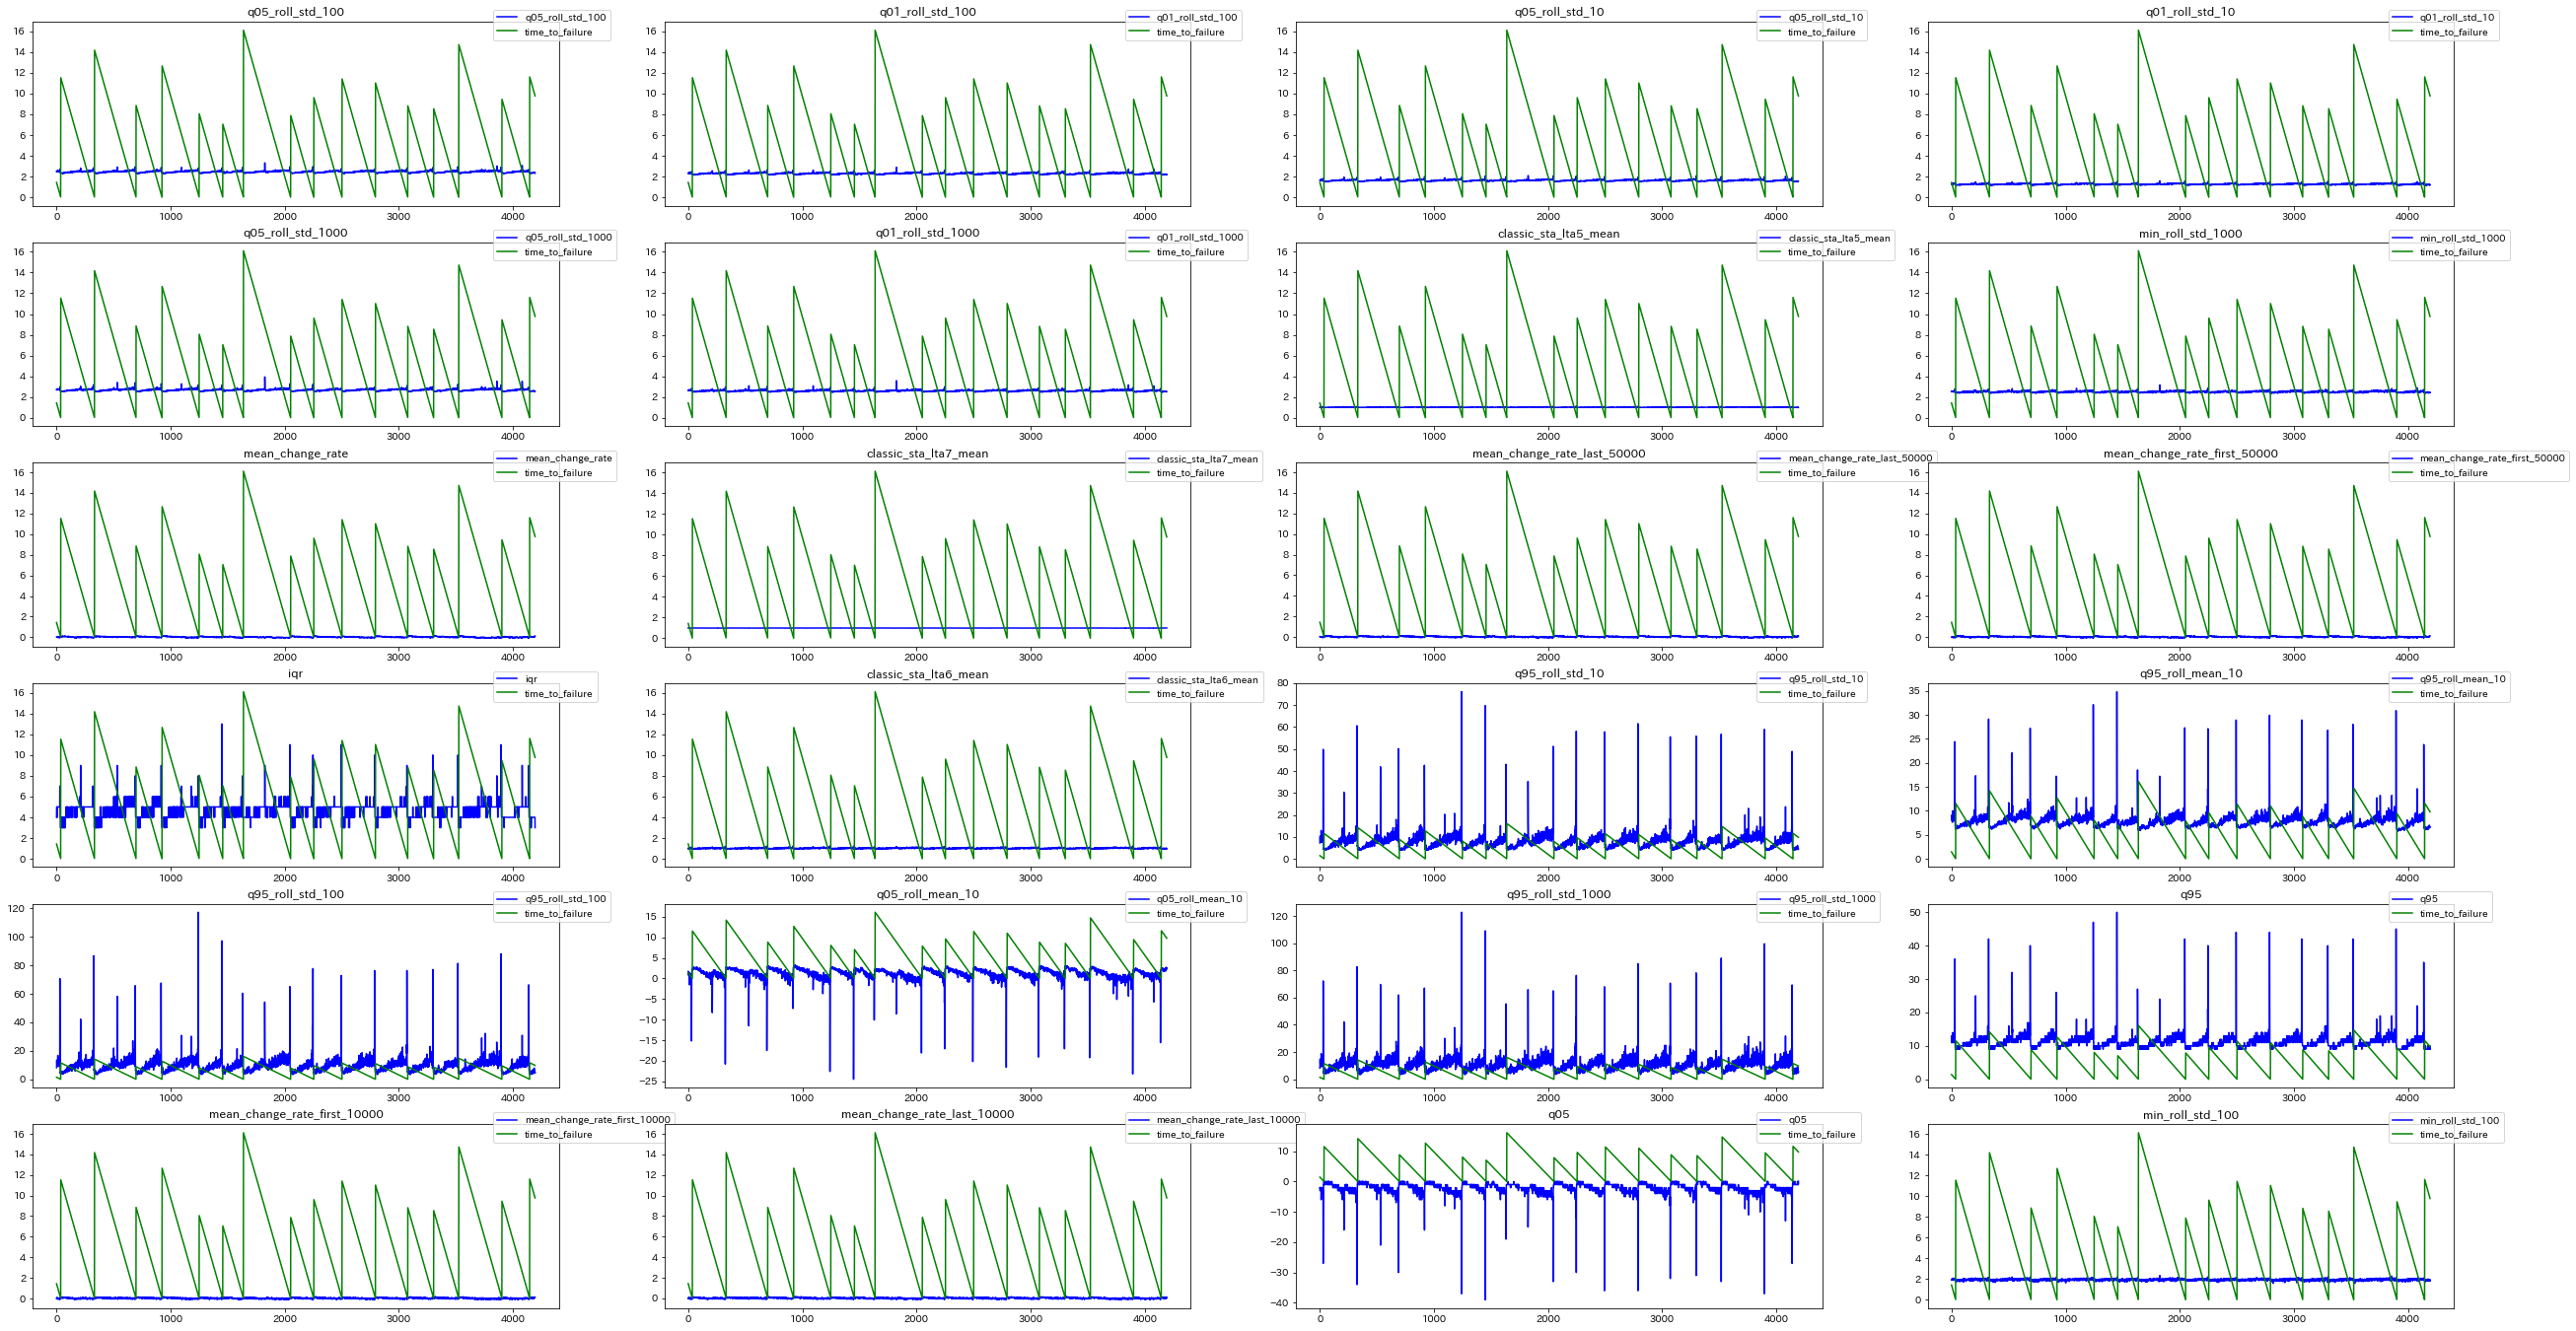

In [23]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [24]:
# 欠損データ保管用の平均値データ
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

In [45]:
# 特徴量間の数値を標準化
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

### Reading test dat

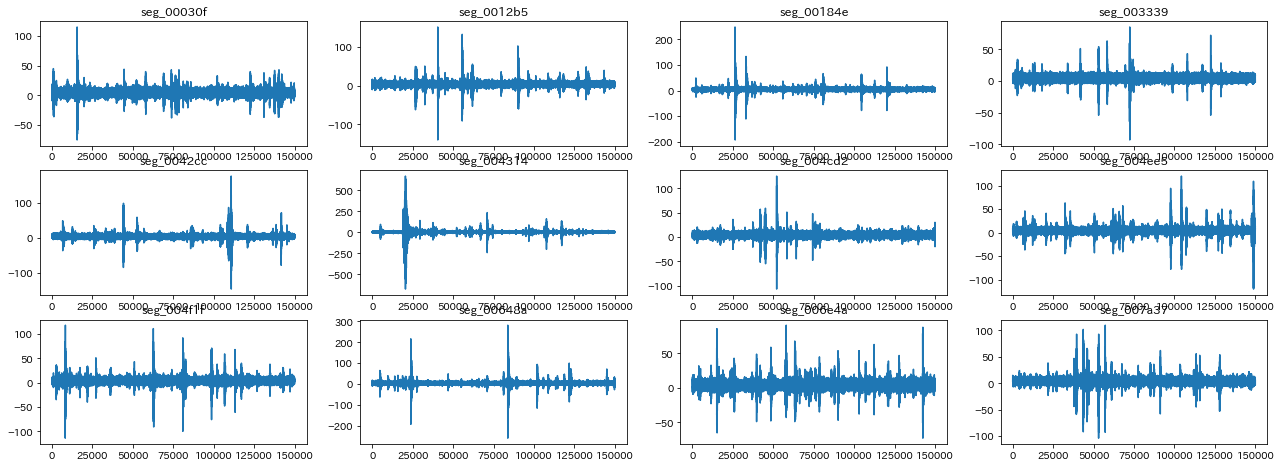

In [26]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    
    generate_features(x_in=x, X_out=X_test, i=seg_id)

    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)
    
# nullが含まれる場合は列の平均値で補正
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

In [ ]:
X_test.to_hdf("../middle/X_test.hdf", key='0')

In [46]:
# 特徴量間の数値を標準化
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [47]:
X_train_scaled.to_hdf("../middle/X_train_scaled.hdf", key='0')
X_test_scaled.to_hdf("../middle/X_test_scaled.hdf", key='0')

## Building models

In [28]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [30]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Tue Apr 16 18:50:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1105]	training's l1: 1.60781	valid_1's l1: 2.06192
Fold 1 started at Tue Apr 16 18:50:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1445]	training's l1: 1.49891	valid_1's l1: 2.00957
Fold 2 started at Tue Apr 16 18:50:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1240]	training's l1: 1.54382	valid_1's l1: 2.11195
Fold 3 started at Tue Apr 16 18:51:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1005]	training's l1: 1.68118	valid_1's l1: 1.89776
Fold 4 started at Tue Apr 16 18:51:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1477]	training's l1: 1.47701	valid_1's l1: 2.0671
CV mean score: 2.0297, std: 0.0735.


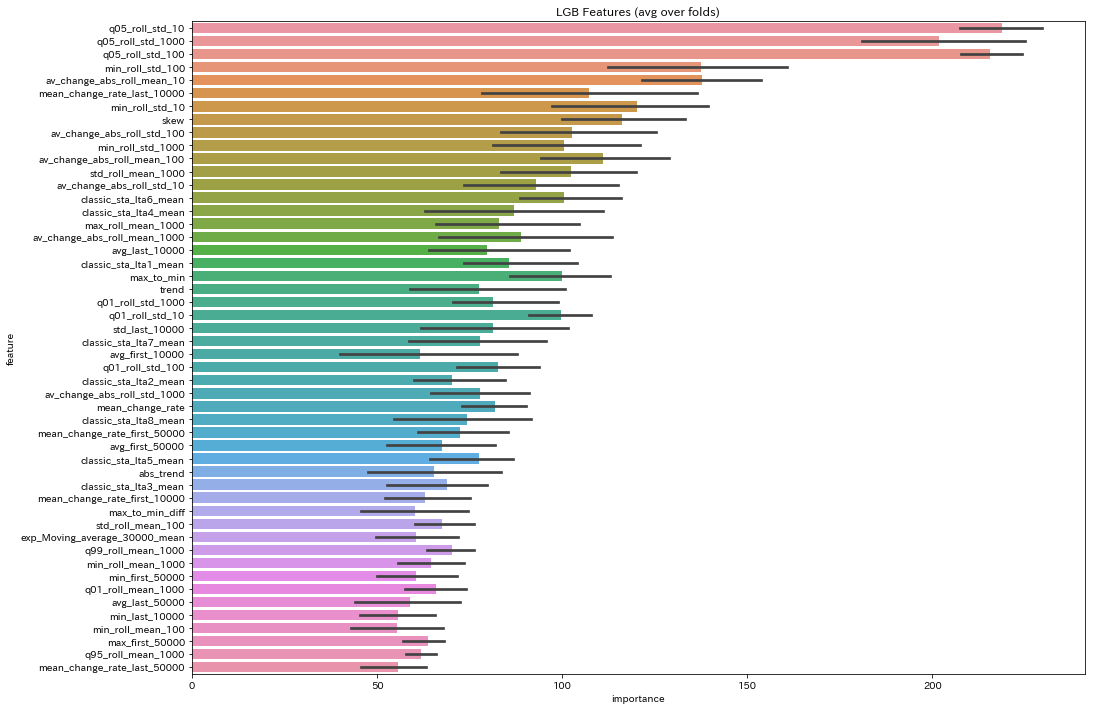

In [49]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [50]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [51]:
# Taking less columns seriously decreases score.
X_train_scaled_top = X_train_scaled[top_cols]
X_test_scaled_top = X_test_scaled[top_cols]

Fold 0 started at Tue Apr 16 18:53:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1260]	training's l1: 1.58648	valid_1's l1: 2.04685
Fold 1 started at Tue Apr 16 18:53:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1115]	training's l1: 1.64719	valid_1's l1: 2.00857
Fold 2 started at Tue Apr 16 18:53:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1253]	training's l1: 1.57686	valid_1's l1: 2.11538
Fold 3 started at Tue Apr 16 18:53:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1253]	training's l1: 1.62172	valid_1's l1: 1.88969
Fold 4 started at Tue Apr 16 18:54:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[910]	training's l1: 1.71363	valid_1's l1: 2.06927
CV mean score: 2.0260, std: 0.0764.


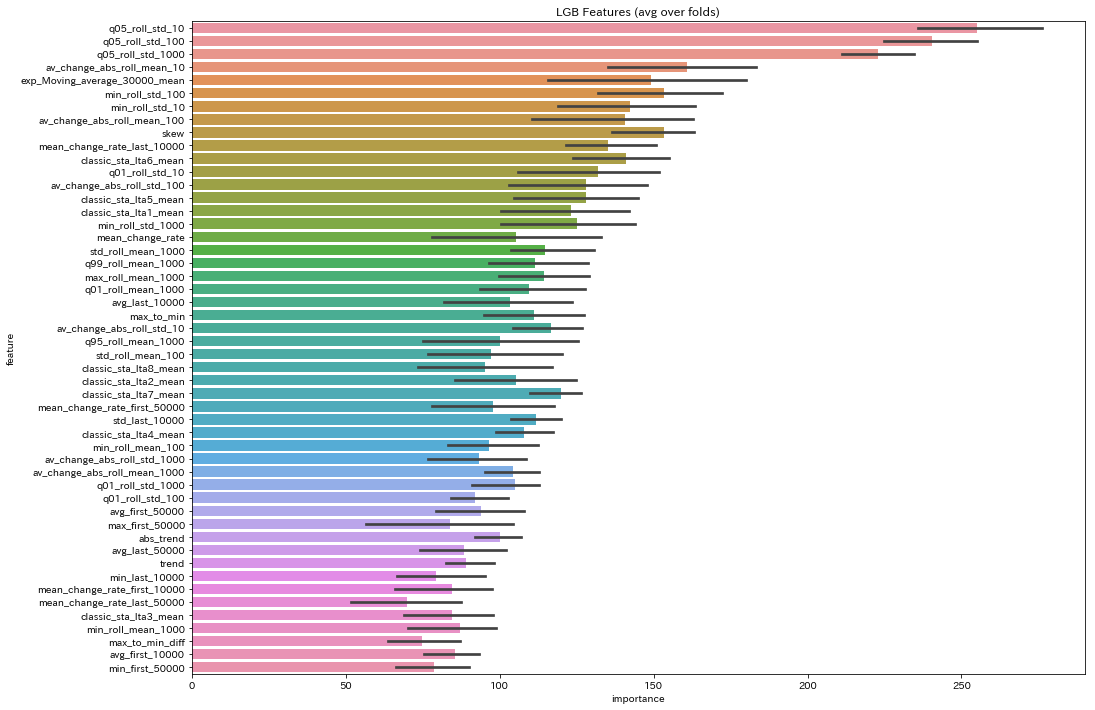

In [52]:
oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train_scaled_top, X_test=X_test_scaled_top, params=params, model_type='lgb', plot_feature_importance=True)

In [53]:
xgb_params = {'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.85,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Tue Apr 16 18:54:34 2019
[0]	train-mae:5.03418	valid_data-mae:5.17584
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[95]	train-mae:0.844874	valid_data-mae:2.13499

Fold 1 started at Tue Apr 16 18:54:40 2019
[0]	train-mae:5.06016	valid_data-mae:5.07126
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[120]	train-mae:0.711688	valid_data-mae:2.04497

Fold 2 started at Tue Apr 16 18:54:46 2019
[0]	train-mae:5.05388	valid_data-mae:5.09524
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[101]	train-mae:0.826382	valid_data-mae:2.12396

Fold 3 started at Tue Apr 16 18:54:51 2019
[0]	tra

In [54]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Apr 16 18:55:10 2019
Fold 0. MAE: 2.1086.

Fold 1 started at Tue Apr 16 18:55:14 2019
Fold 1. MAE: 2.0932.

Fold 2 started at Tue Apr 16 18:55:18 2019
Fold 2. MAE: 2.1601.

Fold 3 started at Tue Apr 16 18:55:21 2019
Fold 3. MAE: 1.9384.

Fold 4 started at Tue Apr 16 18:55:25 2019
Fold 4. MAE: 2.1092.

CV mean score: 2.0819, std: 0.0752.


In [55]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Apr 16 18:55:29 2019
Fold 0. MAE: 2.0773.

Fold 1 started at Tue Apr 16 18:55:32 2019
Fold 1. MAE: 2.0507.

Fold 2 started at Tue Apr 16 18:55:34 2019
Fold 2. MAE: 2.1339.

Fold 3 started at Tue Apr 16 18:55:37 2019
Fold 3. MAE: 1.9043.

Fold 4 started at Tue Apr 16 18:55:40 2019
Fold 4. MAE: 2.0766.

CV mean score: 2.0486, std: 0.0771.


In [59]:
# params = {'loss_function':'MAE'}
# oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

In [58]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Apr 16 19:08:33 2019
Fold 0. MAE: 2.1815.

Fold 1 started at Tue Apr 16 19:08:34 2019
Fold 1. MAE: 2.1689.

Fold 2 started at Tue Apr 16 19:08:35 2019
Fold 2. MAE: 2.2268.

Fold 3 started at Tue Apr 16 19:08:35 2019
Fold 3. MAE: 2.0001.

Fold 4 started at Tue Apr 16 19:08:36 2019
Fold 4. MAE: 2.2336.

CV mean score: 2.1622, std: 0.0848.


### Stacking
And now let's try stacking :) We can use the same function for it.

In [60]:
# train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
# train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])
# test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r, prediction_cat]).transpose()

train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r]).transpose()

test_stack = pd.DataFrame(test_stack)

Fold 0 started at Tue Apr 16 19:09:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's l2: 5.92754	training's l1: 1.9102	valid_1's l2: 7.38533	valid_1's l1: 2.1414
Fold 1 started at Tue Apr 16 19:09:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[24]	training's l2: 5.90946	training's l1: 1.90279	valid_1's l2: 7.20613	valid_1's l1: 2.09632
Fold 2 started at Tue Apr 16 19:09:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[21]	training's l2: 5.90059	training's l1: 1.90491	valid_1's l2: 7.9445	valid_1's l1: 2.19531
Fold 3 started at Tue Apr 16 19:09:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[24]	training's l2: 6.03658	training's l1: 1.93105	valid_1's l2: 6.57909	valid_1's l1: 1.96532
Fold 4 started at Tue Apr 16 19:09:23 2019
Training until v

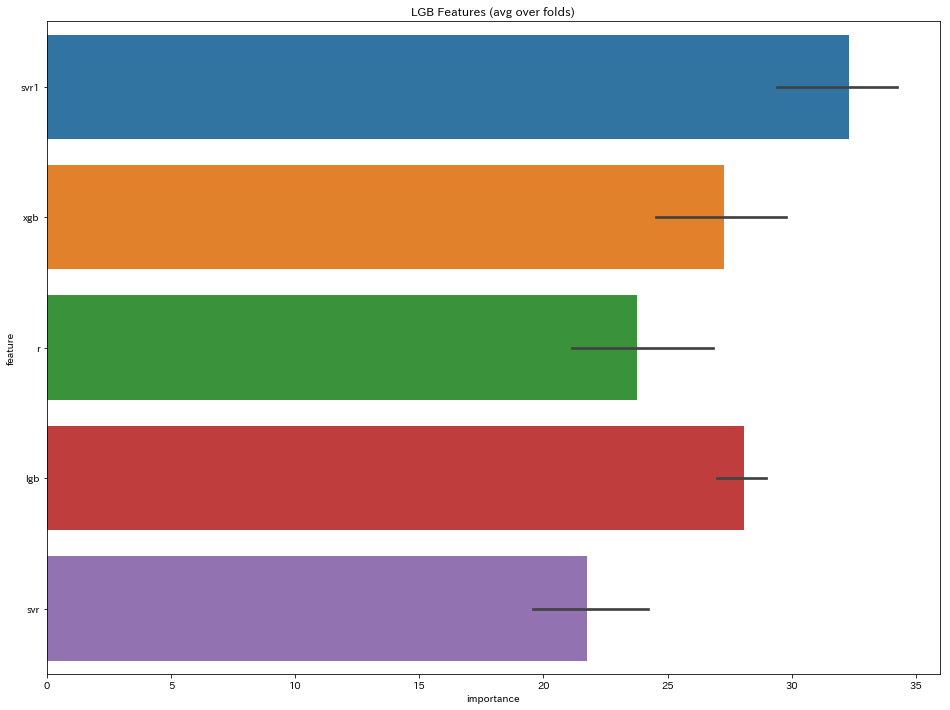

In [61]:
oof_lgb_stack, prediction_lgb_stack, feature_importance = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb', plot_feature_importance=True)

Now let's see how do our models perform

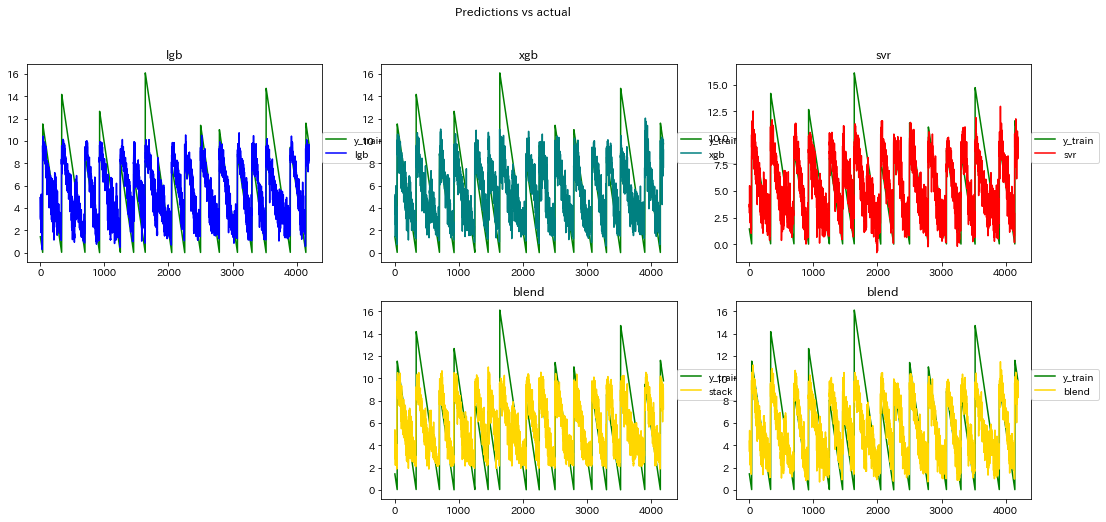

In [70]:
plt.figure(figsize=(18, 8))

plt.subplot(2, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

plt.subplot(2, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');

plt.subplot(2, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend(loc=(1, 0.5));
plt.title('svr');

# plt.subplot(2, 3, 4)
# plt.plot(y_tr, color='g', label='y_train')
# plt.plot(oof_cat, color='b', label='cat')
# plt.legend(loc=(1, 0.5));
# plt.title('cat');

plt.subplot(2, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend(loc=(1, 0.5));
plt.title('blend');

plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

plt.subplot(2, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
#oofs = [oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]
oofs = [oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r]
plt.plot(np.array(oofs).sum(axis=0) / len(oofs), color='gold', label='blend')
plt.legend(loc=(1, 0.5));

plt.title('blend');

plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

It turned out that stacking is much worse than blending on LB.

In [ ]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 + prediction_cat + prediction_r) / 6
# submission['time_to_failure'] = prediction_lgb_stack
print(submission.head())
# submission.to_csv('submission.csv')